In [2]:
!pip3 install torch torchvision -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install numpy accelerate smalldiffusion tqdm diffusers transformers xformers

Looking in links: https://download.pytorch.org/whl/torch_stable.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 93.1 MB/s eta 0:00:00


In [6]:
!pip3 install torch==2.0.1
!pip3 install torchvision==0.15.2 -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install numpy accelerate smalldiffusion tqdm diffusers transformers xformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 MB 11.3 MB/s eta 0:00:00
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.1+cu121
    Uninstalling torchvision-0.20.1+cu121:
      Successfully uninstalled torchvision-0.20.1+cu121
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torch
import numpy as np
import torchvision.transforms.v2.functional as TF
from accelerate import Accelerator
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler
from diffusers.utils.import_utils import is_xformers_available
from transformers import CLIPTextModel, CLIPTokenizer
from torch import nn
from torchvision.utils import save_image, make_grid
from smalldiffusion import ModelMixin, ScheduleLDM
from collections import namedtuple
from itertools import pairwise
from transformers import CLIPProcessor, CLIPModel
from statistics import geometric_mean
from tqdm import tqdm

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
def alpha_bar(sigma):
    return 1/(sigma**2+1)

class ModelLatentDiffusion(nn.Module, ModelMixin):
    def __init__(self, model_key, accelerator=None):
        super().__init__()
        self.accelerator = accelerator or Accelerator()
        self.vae = AutoencoderKL.from_pretrained(model_key, subfolder="vae")
        self.tokenizer = CLIPTokenizer.from_pretrained(model_key, subfolder="tokenizer")
        self.text_encoder = CLIPTextModel.from_pretrained(model_key, subfolder="text_encoder")
        self.unet = UNet2DConditionModel.from_pretrained(model_key, subfolder="unet")
        self.scheduler = DDIMScheduler.from_pretrained(model_key, subfolder="scheduler")
        self.input_dims = (self.unet.config.in_channels, self.unet.sample_size, self.unet.sample_size,)
        self.text_condition = None
        self.text_guidance_scale = None
        if is_xformers_available():
            self.unet.enable_xformers_memory_efficient_attention()
        self.to(self.accelerator.device)

    def tokenize(self, prompt):
        return self.tokenizer(
            prompt, padding='max_length', max_length=self.tokenizer.model_max_length,
            truncation=True, return_tensors='pt'
        ).input_ids.to(self.accelerator.device)

    def embed_prompt(self, prompt):
        with torch.no_grad():
            return self.text_encoder(self.tokenize(prompt))[0]

    @torch.no_grad()
    def decode_latents(self, latents):
        decoded = self.vae.decode(latents / 0.18215).sample
        normalized = (decoded.squeeze()+1)/2 # from [-1,1] to [0, 1]
        return normalized.clamp(0,1)

    def sigma_to_t(self, sigma):
        idx = torch.searchsorted(reversed(self.scheduler.alphas_cumprod.to(sigma)), alpha_bar(sigma))
        return self.scheduler.config.num_train_timesteps - 1 - idx

    def forward(self, x, sigma, cond=None):
        z = alpha_bar(sigma).sqrt() * x
        return self.unet(z, self.sigma_to_t(sigma), encoder_hidden_states=cond).sample

Transform = namedtuple('Transform', ['fwd', 'inv'])
id_t = Transform(lambda x:x, lambda x:x)
r = lambda r: lambda x: TF.rotate(x, r)
rot_180 = Transform(r(180), r(-180))
rot_90 = Transform(r(90), r(-90))

def show_tensor(x):
    display(TF.to_pil_image(x))

def show_tensor_f(x):
    flipped_x = TF.vflip(x)  # Apply horizontal flip
    display(TF.to_pil_image(flipped_x))  # Display the flipped image



def sample_base(model,
           prompt    = 'An astronaut riding a horse',
           N          = 50,
           gam        = 1.,
           mu         = 0.,
           seed       = 0,):
    """
      Generate an image provided a prompt and parameters N, gam, mu.
      The random seed can also be fixed.
    """
    model.eval() # evaluatiuon mode (not training)
    torch.manual_seed(seed) # for reproducibility

    accelerator = Accelerator() # to handle CPU, GPU, TPU

    # Process the empty prompt '' and the input prompt into their encodings
    embeds = torch.cat([model.embed_prompt(''),model.embed_prompt(prompt)])

    print("Empty prompt : ", model.embed_prompt(''))
    print("Prompt 1 : ", model.embed_prompt(prompt))

    # Denoising schedule
    schedule = ScheduleLDM(1000)
    sigmas = schedule.sample_sigmas(N)

    xt = model.rand_input(1).to(accelerator.device) * sigmas[0]
    eps = None

    for i, (sig, sig_prev) in enumerate(tqdm(pairwise(sigmas))):
        # Predict eps with '' and with the prompt
        xts = torch.cat([xt,xt])
        with torch.no_grad(): # no need of backprogation here (save memory)
            eps_uncond,eps_cond = model.predict_eps(xts, sig.to(xt), embeds).chunk(N)
        # Hardcoded weighted average of the two computed eps
        eps_prev, eps = eps, eps_uncond*(-6.5) + eps_cond*7.5

        # Applying various modifications to improve the update
        eps_av = eps * gam + eps_prev * (1-gam)  if i > 0 else eps
        sig_p = (sig_prev/sig**mu)**(1/(1-mu))
        eta = (sig_prev**2 - sig_p**2).sqrt()

        # Update latent space
        xt = xt - (sig - sig_p) * eps_av + eta * model.rand_input(xt.shape[0]).to(xt)

    # Convert from latent space to image
    image = model.decode_latents(xt)

    return image

In [5]:
model    = ModelLatentDiffusion('stabilityai/stable-diffusion-2-1-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vae/config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

Empty prompt :  tensor([[[-3.1343e-01, -4.4757e-01, -8.2413e-03,  ...,  2.5421e-01,
          -3.2432e-02, -2.9603e-01],
         [ 1.4114e+00,  7.5768e-03, -4.2884e-01,  ...,  1.0365e+00,
          -6.7341e-01,  1.5006e+00],
         [ 1.8676e+00, -1.0888e+00, -1.0656e+00,  ...,  2.0319e+00,
          -1.1396e+00, -1.8952e-01],
         ...,
         [ 6.0623e-03, -1.4990e+00, -3.9075e-01,  ..., -1.7927e-01,
          -3.2250e-01, -1.5237e-02],
         [ 2.7660e-02, -1.5532e+00, -4.1507e-01,  ..., -4.4162e-01,
          -3.9632e-01,  1.9090e-01],
         [-7.0735e-02, -2.6132e+00, -1.0513e+00,  ...,  1.0089e-03,
          -5.0300e-01,  4.0609e-01]]], device='cuda:0')
Prompt 1 :  tensor([[[-0.3134, -0.4476, -0.0082,  ...,  0.2542, -0.0324, -0.2960],
         [ 2.1447,  0.3832, -0.4935,  ...,  0.5082, -0.3335, -0.0968],
         [ 0.3318, -0.5581,  0.6935,  ..., -0.8740, -0.6722, -1.1797],
         ...,
         [ 0.5132, -1.4351,  0.5437,  ..., -0.4231, -0.0569,  0.2568],
         [ 

25it [00:10,  2.32it/s]


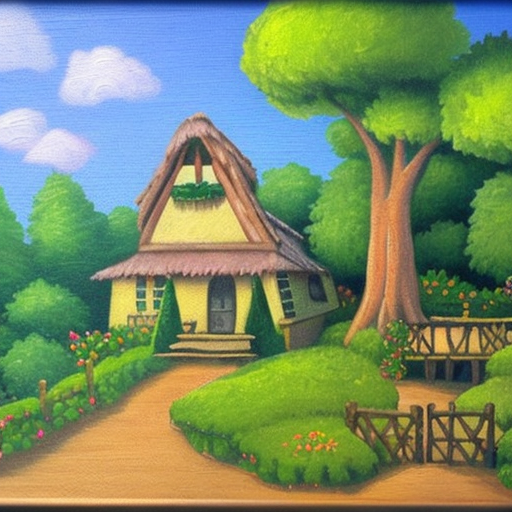

In [ ]:
img = sample_base(
        model, gam=1.7, N=25, seed=7,
        prompt= 'House in the woods, oil painting, ghibli inspired, high resolution',
    )
show_tensor(img)

# Illusion

In [6]:
from torchvision.transforms.functional import hflip
from torchvision.transforms.functional import vflip

def sample_base_i(model,
           prompt1    = 'An astronaut riding a horse',
           prompt2    = 'House in the woods',
           c          = 0.5,
           N          = 50,
           gam        = 1.,
           mu         = 0.,
           seed       = 0,):
    model.eval() # evaluatiuon mode (not training)
    torch.manual_seed(seed) # for reproducibility

    accelerator = Accelerator() # to handle CPU, GPU, TPU

    # Process the empty prompt '' and the input prompt into their encodings
    #embeds = torch.cat([model.embed_prompt(''),model.embed_prompt(prompt)])

    # Denoising schedule
    schedule = ScheduleLDM(1000)
    sigmas = schedule.sample_sigmas(N)

    xt = model.rand_input(1).to(accelerator.device) * sigmas[0]
    eps = None

    for i, (sig, sig_prev) in enumerate(tqdm(pairwise(sigmas))):
        # Predict eps with '' and with the prompt
        xts = torch.cat([xt,xt])
        with torch.no_grad(): # no need of backprogation here (save memory)
            #eps_uncond,eps_cond = model.predict_eps(xts, sig.to(xt), embeds).chunk(N)
            eps00 = model.predict_eps(xt, sig, model.embed_prompt(''))

            eps01 = model.predict_eps(xt, sig, model.embed_prompt(prompt1))

            flip_xt = vflip(xt) #flip : TF.hflip(xt) or rot : rot_180.fwd(xt) ??
            #flip_xt = rot_180.fwd(xt)
            eps10 = model.predict_eps(flip_xt, sig, model.embed_prompt(''))

            eps11 = model.predict_eps(flip_xt, sig, model.embed_prompt(prompt2))

        # Hardcoded weighted average of the two computed eps
        eps_prev, eps = eps, (1-c)/2*(eps00 + vflip(eps10)) + c/2*eps01 + c/2*vflip(eps11)
        #eps_prev, eps = eps, (1-c)/2*(eps00 + rot_180.fwd(eps10)) + c/2*eps01 + c/2*rot_180.fwd(eps11)

        # Applying various modifications to improve the update
        eps_av = eps * gam + eps_prev * (1-gam)  if i > 0 else eps
        sig_p = (sig_prev/sig**mu)**(1/(1-mu))
        eta = (sig_prev**2 - sig_p**2).sqrt()

        # Update latent space
        #xt = xt - (sig - sig_p) * eps_av + eta * model.rand_input(xt.shape[0]).to(xt)
        xt = xt - (sig - sig_prev)*eps

    # Convert from latent space to image
    image = model.decode_latents(xt)

    return image

In [ ]:
model    = ModelLatentDiffusion('stabilityai/stable-diffusion-2-1-base')

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 1.06 MiB is free. Process 4425 has 14.74 GiB memory in use. Of the allocated memory 14.53 GiB is allocated by PyTorch, and 92.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

For some reasons, the first prompt appears to be dominant over the second one.
Maybe change weights in sample function

25it [00:26,  1.06s/it]


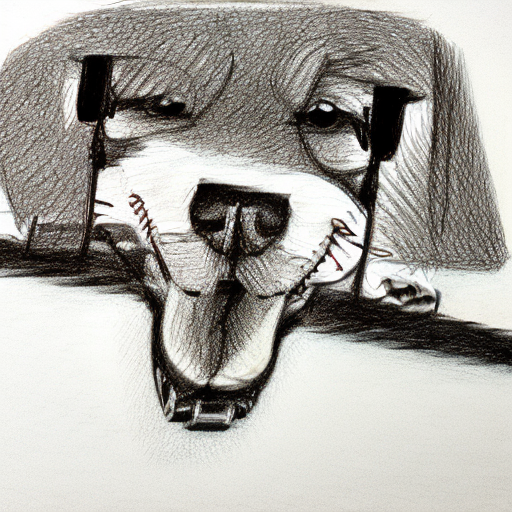

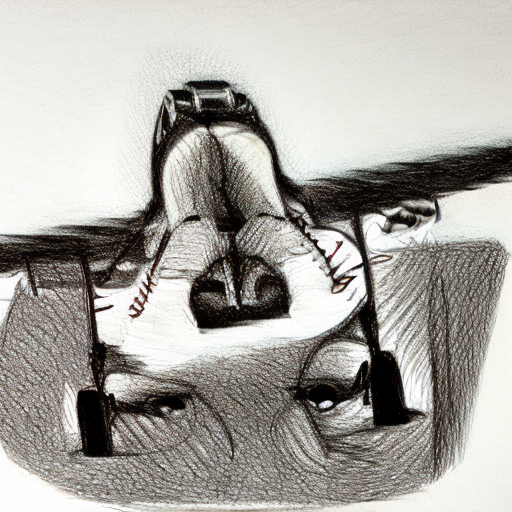

In [8]:
img = sample_base_i(
        model,
        prompt1 = 'drawing of a dog',
        prompt2 = 'drawing of a plane',
        c = 25., gam=1.7, N=25, seed=6,
    )
show_tensor(img)
print(' ')
show_tensor_f(img)

25it [00:25,  1.01s/it]


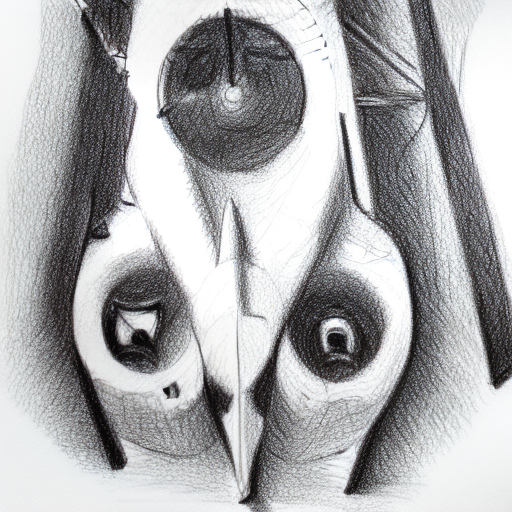

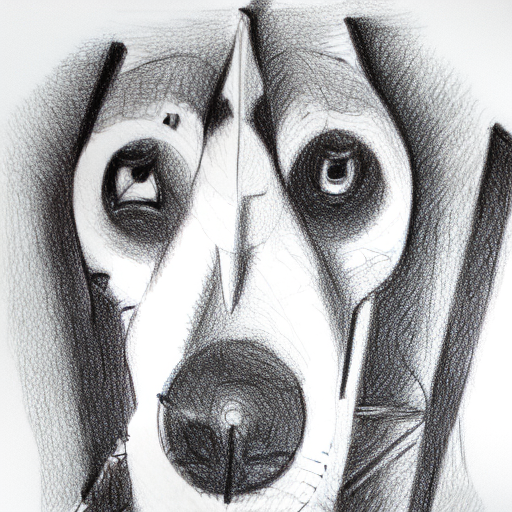

In [9]:
img = sample_base_i(
        model,
        prompt1 = 'drawing of a plane',
        prompt2 = 'drawing of a dog',
        c = 25., gam=1.7, N=25, seed=6,
    )
show_tensor(img)
print(' ')
show_tensor_f(img)

25it [00:25,  1.03s/it]


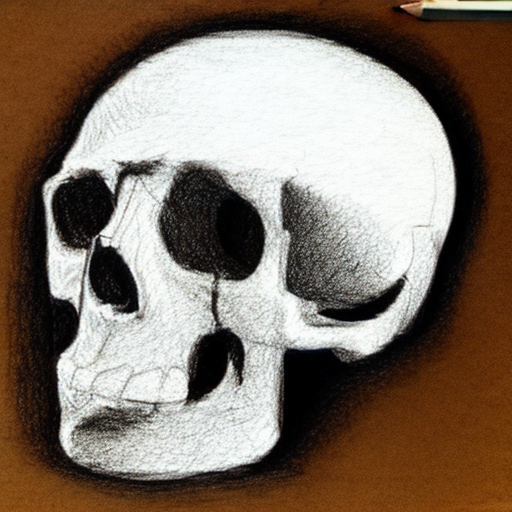

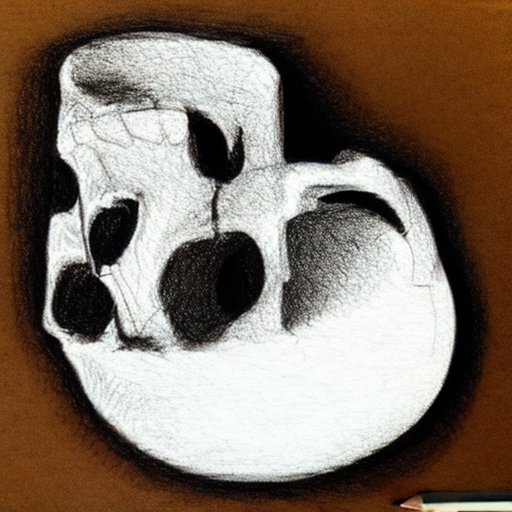

In [9]:
img = sample_base_i(
        model,
        prompt1 = 'drawing of a skull',
        prompt2 = 'drawing of a mug',
        c = 25., gam=1.7, N=25, seed=8,
    )
show_tensor(img)
print(' ')
show_tensor_f(img)

25it [00:26,  1.06s/it]


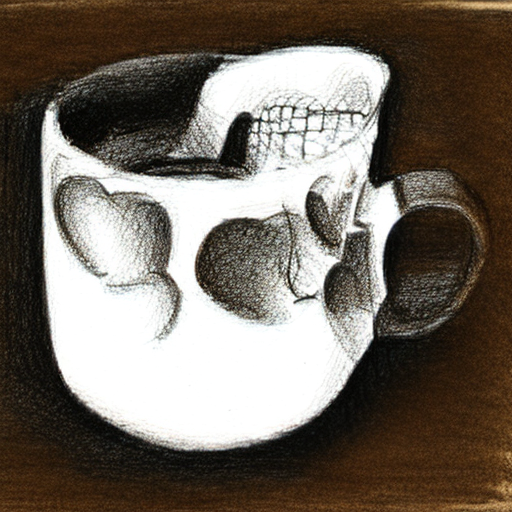

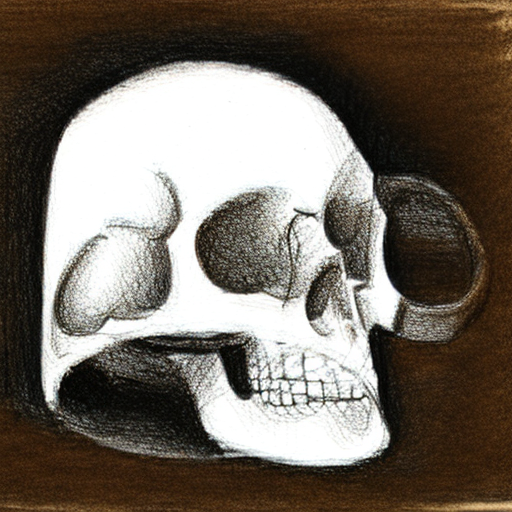

In [10]:
img = sample_base_i(
        model,
        prompt1 = 'drawing of a mug',
        prompt2 = 'drawing of a skull',
        c = 25., gam=1.7, N=25, seed=8,
    )
show_tensor(img)
print(' ')
show_tensor_f(img)

# Own way of creating illusions

In [ ]:
def sample_base_i(model,
           prompt1    = 'An astronaut riding a horse',
           prompt2    = 'House in the woods',
           c          = 0.5,
           N          = 50,
           gam        = 1.,
           mu         = 0.,
           seed       = 0,):
    model.eval() # evaluatiuon mode (not training)
    torch.manual_seed(seed) # for reproducibility

    accelerator = Accelerator() # to handle CPU, GPU, TPU

    # Process the empty prompt '' and the input prompt into their encodings
    #embeds = torch.cat([model.embed_prompt(''),model.embed_prompt(prompt)])

    # Denoising schedule
    schedule = ScheduleLDM(1000)
    sigmas = schedule.sample_sigmas(N)

    xt = model.rand_input(1).to(accelerator.device) * sigmas[0]
    eps = None

    for i, (sig, sig_prev) in enumerate(tqdm(pairwise(sigmas))):
        # Predict eps with '' and with the prompt
        xts = torch.cat([xt,xt])
        with torch.no_grad(): # no need of backprogation here (save memory)
            #eps_uncond,eps_cond = model.predict_eps(xts, sig.to(xt), embeds).chunk(N)
            eps00 = model.predict_eps(xt, sig, model.embed_prompt(''))

            eps01 = model.predict_eps(xt, sig, model.embed_prompt(prompt1))

            flip_xt = vflip(xt) #flip : TF.hflip(xt) or rot : rot_180.fwd(xt) ??
            #flip_xt = rot_180.fwd(xt)
            eps10 = model.predict_eps(flip_xt, sig, model.embed_prompt(''))

            eps11 = model.predict_eps(flip_xt, sig, model.embed_prompt(prompt2))

        # Hardcoded weighted average of the two computed eps
        eps_prev, eps = eps, (1-c)/2*(eps00 + vflip(eps10)) + c/2*eps01 + c/2*vflip(eps11)
        #eps_prev, eps = eps, (1-c)/2*(eps00 + rot_180.fwd(eps10)) + c/2*eps01 + c/2*rot_180.fwd(eps11)

        # Applying various modifications to improve the update
        eps_av = eps * gam + eps_prev * (1-gam)  if i > 0 else eps
        sig_p = (sig_prev/sig**mu)**(1/(1-mu))
        eta = (sig_prev**2 - sig_p**2).sqrt()

        # Update latent space
        #xt = xt - (sig - sig_p) * eps_av + eta * model.rand_input(xt.shape[0]).to(xt)
        xt = xt - (sig - sig_prev)*eps

    # Convert from latent space to image
    image = model.decode_latents(xt)

    return image